# Hands-on week 2, Data science in Neuroscience

You can download this Notebook from https://github.com/kevin-allen/dataScienceNeuro


## Plan for today

1. Review our machine example so far
2. Measuring model performance
3. Gradient descent
4. Training loop
5. Exercise
***

## Review

### Simulation of our speed cell

Yesterday, we started to work with our linear regression model. 

For a linear regression, the model is $Y = Xw + b$

In machine learning lingo, $w$ is the weight, and $b$ is the bias.

Our formula for simulating the firing rate is

$rate = speed*w + b + error$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fn = "../data/animal_speed.npy"

In [3]:
speed = np.load(fn)

w = 1.25 # parameter 2
b = 10 # parameter 1
np.random.seed(0)
e = np.random.normal(loc=0.0, scale=5, size = speed.shape[0]) # random numbers taken from a normal distribution

rate = speed * w + b + e
rate = np.maximum(0, rate) # eliminate the negative firing rates

In [4]:
e

array([8.82026173, 2.00078604, 4.89368992, ..., 2.11282899, 7.93865769,
       5.00526146])

### Model prediction with matrix multiplication

We used matrix multiplication to make predictions with our model. 

* We created a matrix with our model coefficients (1,2)
* We created a matrix with our speed data (2x27304)


$ \begin{bmatrix} b & w \end{bmatrix} * \begin{bmatrix} 1 & 1 & 1 & 1 \\ speed_0 & speed_1 & speed_2 & speed_3 \end{bmatrix} = \begin{bmatrix} y_0 & y_1 & y_2 & y_3 \end{bmatrix}$


Each element of y results from $b*1+w*speed$, which is our linear model.

* The multiplication gives a matrix of shape (1,27304). This matrix contains the prediction of the model for 27304 data point.

In [5]:
theta = np.array([[0.0,3.0]]) # random guess of the 2 model parameters, same as above
X = np.ones((2,speed.shape[0]))  # make a 2 rows array with ones in the first row and speed in the second row
X[1,:] = speed

Model prediction using $theta@X$

In [6]:
theta.shape, X.shape

((1, 2), (2, 27304))

In [7]:
yhat = theta@X

In [8]:
yhat

array([[49.68329766, 55.18778178, 44.91174883, ..., 80.04574821,
        79.2355093 , 78.89726005]])

In [9]:
rate

array([39.52163576, 34.99569512, 33.6069186 , ..., 45.46522408,
       50.95345323, 47.87911982])

In [10]:
yhat.shape

(1, 27304)

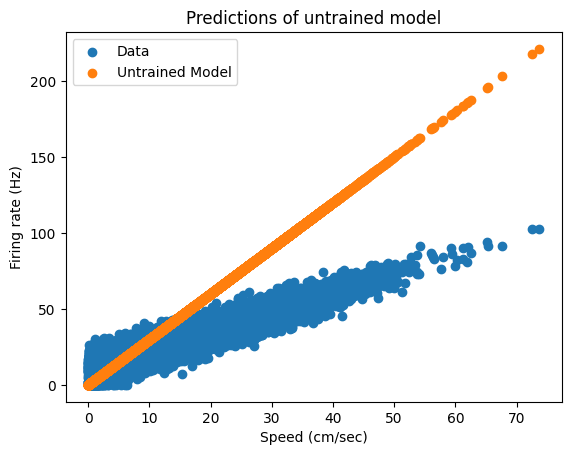

In [11]:
plt.scatter(speed,rate,label="Data")
plt.scatter(speed,yhat,label="Untrained Model")
plt.title("Predictions of untrained model")
plt.xlabel("Speed (cm/sec)")
plt.ylabel("Firing rate (Hz)")
plt.legend()
plt.show()

## Measuring model performance

To be able to train any model, you need a measure of how bad it is doing it is doing. This is usually refer to as a `loss function`.

For linear regression model, the mean squared error (MSE) is often used. 


$MSE = \frac{1}{m} \sum_{i = 1}^{m}(\hat{y}^{i} - y^{i})^2$, where

* $m$ is the number of data points
* $y$ is the measured dependent variable (firing rate of the neuron) 
* $\hat{y}$ is the prediction of the model


### Exercise:

Calculate the mean squared error (MSE) for our untrained model

In [11]:
m = yhat.shape[1]

In [12]:
(1/m) * np.sum((yhat-rate)**2)

457.7375553920619

In [13]:
np.mean((yhat-rate)**2)

457.7375553920619

The task of the training loop (machine learning) in this exercise is to modify the model parameters to reduce the MSE to the smallest value possible.

## Training procedure using gradient descent

We want to tweak the parameters with the goal of reducing the MSE. 

One way to do this is to use an optimization algorithm called **gradient descent**. 

Gradient descent is capable of finding optimal solutions to many type of problems/functions.


<div>
<img src="../images/gradient_descent.png" width="1000"/>
</div>


With gradient descent, we calculate the slope of the loss function with the current parameters, then we change the parameters so that we move down the slope. 

The amount by which we move down the slope is controlled by a model hyperparameter called `learning rate`.

The model hyperparameters are not optimized from the data. They control how the model learns. 

We can have a look at the cost function as a function of different values of $\theta_1$ or $w$. This is the slope of our model.

In [12]:
print(rate.shape)
rateM = np.expand_dims(rate,0) # creating a matrix with one row and 27304 column, just like yhat.
print(rateM.shape)

(27304,)
(1, 27304)


In [13]:
theta = np.array([[10.0,2.0]]) 

In [14]:
theta.shape, X.shape

((1, 2), (2, 27304))

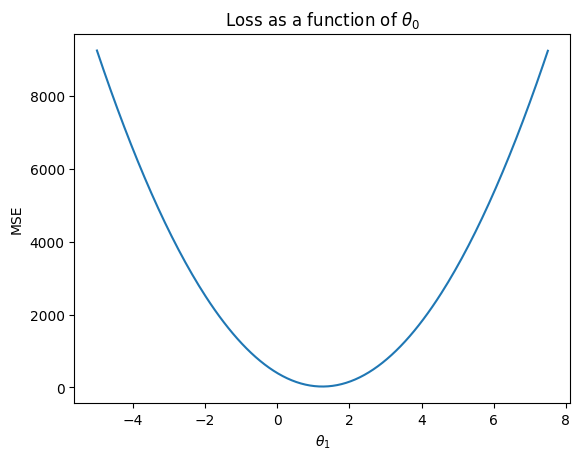

In [15]:
nDataPoints=200
theta[0,0]=10.0 # I am cheating and set b to the correct value to see if the loss function will have a minimum at the correct value of w

res = np.empty(nDataPoints)
param_values = np.linspace(-5.0,7.5,nDataPoints)
for i,t in enumerate(param_values):
    theta[0,1]=t # change the second parameter of the model
    res[i] = np.mean((rateM-theta@X)**2) # calculate the loss (MSE) with the new parameter value
plt.plot(param_values,res) # plot the loss as a function of the parameter
plt.xlabel(r"$\theta_1$")
plt.ylabel("MSE")
plt.title(r"Loss as a function of $\theta_0$")
plt.show()

### Partial derivative of the cost function

To be able to adjust the parameters in the right direction, we need to know the slope for a specific value of $\theta$.

This is called the partial derivative for our parameters.

For the case of the MSE, the formula for the partial derivative is:

$\nabla_{\theta}MSE(\theta) = \frac{2}{m} (\theta X - y)X^{T}$

* $y$ is the firng rate.
* $X^{T}$ is the transpose of $X$. In NumPy, this is `X.T`.

### Exercise:

Write the code that will give you the partial derivative.

In the training loop, negative gradients mean that you increase the values of the coefficients to reduce the MSE.

Because we use all observations to calculate the gradients, this is called **batch gradient descent**.

For more complex models, you can use [pytorch](https://pytorch.org/) to calculate the derivative for you automatically.

### Our first training loop

This is a simple training loop. We loop several times and make small adjustments to the coefficients on each iteration.

In [22]:
lr = 0.002 # learning rate
n_iterations = 6000 
m = rate.shape[0] # number of data points

#theta = np.random.rand(2) # set random parameters as a starting point
theta = np.array([[20.0,-2.0]]) 
print("theta at start:", theta)

# learning loop
for iteration in range(n_iterations):

    
    # make a prediction by feeding data to our model
    yhat = theta@X
    
    # calculate the gradients with the current parameters
    gradients = 2/m *(yhat - rateM) @ X.T
    
    # adjust the parameter so that we reduce the MSE
    theta = theta - lr * gradients

    if iteration%1000 == 0 or iteration<10:  # some information
        print("iteration:{}, gradients: {}".format(iteration,gradients))

print("optimized theta:",theta)

theta at start: [[20. -2.]]
iteration:0, gradients: [[  -52.12155036 -1312.69499501]]
iteration:1, gradients: [[  6.3601809 -71.1166835]]
iteration:2, gradients: [[ 9.4917568  -4.26051724]]
iteration:3, gradients: [[ 9.64292294 -0.65968656]]
iteration:4, gradients: [[ 9.6336361 -0.4649713]]
iteration:5, gradients: [[ 9.61574259 -0.45366692]]
iteration:6, gradients: [[ 9.59741884 -0.45224024]]
iteration:7, gradients: [[ 9.57910504 -0.451347  ]]
iteration:8, gradients: [[ 9.56082485 -0.45048405]]
iteration:9, gradients: [[ 9.54257947 -0.44962428]]
iteration:1000, gradients: [[ 1.43732497 -0.06772343]]
iteration:2000, gradients: [[ 0.21280311 -0.01002679]]
iteration:3000, gradients: [[ 0.03150656 -0.00148452]]
iteration:4000, gradients: [[ 0.0046647  -0.00021979]]
iteration:5000, gradients: [[ 6.90632390e-04 -3.25410011e-05]]
optimized theta: [[9.95650957 1.25322235]]


## Exercise: 

* Use our optimized model to make rate predictions 
* Plot the predicted and observed firing rates as a function of running speed. 

### Visualisation of the training process

Here I created a small animation to visualize the training process. 

Don't worry about all the details relating to plotting the data. The training process is exactly the same as above. 

We save training parameters $w$ and $b$, the MSE and the gradients in numpy arrays at each iteration, and use this data to generate a plot for each iteration. We then put all images together to create an animation.

The code takes approximately a minute to run.

In [23]:
import imageio
import os

In [24]:
lr = 0.002
n_epochs = 3000 # how many time we go through the data during the learning process, one epoch = one pass through the data.
m = rate.shape[0]
theta = np.array([[-10,-10]])

# variables for our animation
animation_dir = "../images/learning_animation/"
imageFileNames = []
save_every = 25

# arrays to store the results at each iteration
mseLearning = np.empty(n_epochs)
tLearning = np.empty((n_epochs,2))
gradLearning = np.empty((n_epochs,2))


for epoch in range(n_epochs):
    gradients = 2/m *(theta@X - rateM) @ X.T
    
    # save results for the animation
    mseLearning[epoch] = np.mean((rate-theta@X)**2)
    tLearning[epoch,:] = theta
    gradLearning[epoch,:] = gradients
    
    
    # change the parameters
    theta = theta - lr * gradients
    
    
    # make one figure for our animation

    if epoch < 5 or epoch % save_every == 0:
        fn = os.path.join(animation_dir,"image_{}.png".format(epoch))
        imageFileNames.append(fn)
        fig, ax = plt.subplots(1,4,figsize=(13,3),layout="constrained")
    
        # plot the MSE
        ax[0].plot(np.arange(epoch),mseLearning[:epoch])
        ax[0].set_xlim(0,n_epochs)
        ax[0].set_ylim(0,200)
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss (MSE)")
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False) 
        ax[0].set_title("MSE")
        
        # plot the gradients
        ax[1].plot(np.arange(epoch),gradLearning[:epoch,1],label="$w$ gradient")
        ax[1].plot(np.arange(epoch),gradLearning[:epoch,0],label="$b$ gradient")
        ax[1].set_xlim(0,n_epochs)
        ax[1].set_ylim(-10,1)
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Gradients")
        ax[1].legend(loc=4)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False) 
        ax[1].set_title("Gradients")
    
        # plot the parameters
        ax[2].scatter(tLearning[:epoch,0],tLearning[:epoch,1],color="gray",s=3,alpha=0.5)
        ax[2].scatter(tLearning[epoch,0],tLearning[epoch,1],color="red",s=5)
        ax[2].set_xlim(-10,12)
        ax[2].set_ylim(-0.5,3)
        ax[2].set_xlabel("$b$")
        ax[2].set_ylabel("$w$")
        ax[2].text(-0.5, 2.5, "Epoch {}/{}".format(epoch,n_epochs))
        ax[2].spines['top'].set_visible(False)
        ax[2].spines['right'].set_visible(False)
        ax[2].set_title("Parameters")
    
        # plot the data and regression line
        x=np.arange(70)
        y = x*theta[0,1] + theta[0,0]
        
        
        ax[3].scatter(speed[::10],rate[::10],label="Data",alpha=0.5,s=1) # only plot every 10 data points to speed up plot function
        ax[3].plot(x,y,label="Model",color="red")
        ax[3].set_xlabel("Speed (cm/sec)")
        ax[3].set_ylabel("Firing rate (Hz)")
        ax[3].set_xlim(0,70)
        ax[3].set_ylim(-10,130)
        ax[3].legend(loc=4)
        ax[3].set_title("Data and Model")
        ax[3].spines['top'].set_visible(False)
        ax[3].spines['right'].set_visible(False)
        
        plt.savefig(fn)
        plt.close()
 
print("optimized theta:",theta)


optimized theta: [[9.89349625 1.2561914 ]]


We can make the animation from our saved image

In [25]:
fn = os.path.join(animation_dir,"learning_animation.gif")
with imageio.get_writer(fn, mode='I',loop=0) as writer:
    for filename in imageFileNames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)
# Remove files
for filename in set(imageFileNames):
    os.remove(filename)

<img src="../images/learning_animation/learning_animation.gif" width="1000" align="center">

## Alternative ways to find the best parameters

### sklearn.linear_model.LinearRegression

Scikit-Learn had built in classes to train linear and non-linear regression models. 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X.T,rate)
lin_reg.intercept_,lin_reg.coef_

(10.021477375759808, array([0.        , 1.25062161]))

### pytorch

pytorch is a platform use principally to train deep neural network. 

With pytorch, we need to put our data and model in torch.tensor objects instead of NumPy array. They work similarly for the most part. 

pytorch can calculate the derivative for you. The computations can be sent to the GPU if needed (not implemented here)


In [79]:
import torch

# linear model making prediction
def model(X,theta):
    return theta@X
# loss function returning MSE
def loss_fn(y,yhat):
    squared_diff = (y-yhat)**2
    return squared_diff.mean()

# model parameters stored as a pytorch tensor. This makes the calculation of the gradients possible
theta = torch.tensor([[20.0,-2.0]],requires_grad =True)
print("theta at start:", theta)

# We transform our data from NumPy array to Pytorch tensors. There is no need for gradients
XTensor = torch.tensor(X,dtype=torch.float32)
rateTensor= torch.tensor(rate,dtype=torch.float32)

# let's run the model once and calculate the loss
yhat = model(XTensor,theta)
loss = loss_fn(yhat,rateTensor)
print("loss:",loss)
loss.backward()

print("gradients: ",theta.grad)

# We need to zero the gradients; otherwise, they accumulate
theta.grad.zero_()


theta at start: tensor([[20., -2.]], requires_grad=True)
loss: tensor(1898.0017, grad_fn=<MeanBackward0>)
gradients:  tensor([[  -52.1216, -1312.6951]])


tensor([[0., 0.]])

In [80]:
## training loop that will modify our parameters to minimize the loss function (MSE)
def training_loop(n_epochs, learning_rate, theta, XTensor,rateTensor):
    for epoch in range (n_epochs):

        if theta.grad is not None:
            theta.grad.zero_() 
        
        yhat = model(XTensor,theta)
        loss = loss_fn(yhat,rateTensor)
        loss.backward()
        
        with torch.no_grad():
            theta -= learning_rate * theta.grad
        
        if epoch % 1000 ==0 or epoch < 10:
            print("Epoch: {}, Loss: {}, theta: {}, Gradients: {}".format(epoch,loss, theta, theta.grad))
    return theta

In [24]:
opt_theta = training_loop(n_epochs = 10000,
                          learning_rate = 0.001,
                          theta = torch.tensor([20.0,-2.0],requires_grad =True),
                          XTensor = XTensor,
                          rateTensor=rateTensor)
print(opt_theta)

Epoch: 0, Loss: 1898.279541015625, theta: tensor([20.0522, -0.6871], requires_grad=True), Gradients: tensor([  -52.1939, -1312.9094])
Epoch: 1, Loss: 580.1749877929688, theta: tensor([2.0075e+01, 4.9269e-03], requires_grad=True), Gradients: tensor([ -22.9481, -692.0174])
Epoch: 2, Loss: 214.13821411132812, theta: tensor([20.0827,  0.3698], requires_grad=True), Gradients: tensor([  -7.5422, -364.8546])
Epoch: 3, Loss: 112.44169616699219, theta: tensor([20.0821,  0.5622], requires_grad=True), Gradients: tensor([   0.5713, -192.4646])
Epoch: 4, Loss: 84.138916015625, theta: tensor([20.0773,  0.6639], requires_grad=True), Gradients: tensor([   4.8421, -101.6281])
Epoch: 5, Loss: 76.21393585205078, theta: tensor([20.0702,  0.7176], requires_grad=True), Gradients: tensor([  7.0881, -53.7640])
Epoch: 6, Loss: 73.94693756103516, theta: tensor([20.0619,  0.7462], requires_grad=True), Gradients: tensor([  8.2673, -28.5431])
Epoch: 7, Loss: 73.2509994506836, theta: tensor([20.0530,  0.7614], requ

Once again we found our initial parameters.

This type of output is very similar to what you see when you train DeepLabCut (more on this next week).

## Summary

* We implemented a linear regression model in python.
* We defined a cost function (MSE) to measure how good/bad the model predictions are.
* We calculated the partial derivative of the MSE for a set of coefficients.
* We wrote a training loop to adjust the coefficients iteratively in order to minimize MSE
* We covered 3 possible ways in which you can train models (klearn.linear_model, scipy.optimize.minimize and pytorch)


# Machine learning challenge

A new paper comes out on speed cells. The authors suggest that the firing rate of speed cells depends on both speed and acceleration. 

Two factors are influencing the firing rate of the neuron. 

You would like to create a linear regression model that predict the firing rate of these cells.

Your new model is as follows.

$rate = speed*w_1 + acceleration*w_2 + b + error$

In this model you will have 3 coefficients, $\theta_0, \theta_1, \theta_2$


In [81]:
fn = "../data/animal_acceleration.npy"
acceleration = np.load(fn)

In [82]:
fn = "../data/animal_speed.npy"
speed = np.load(fn)

In [83]:
fn =  "../data/y_rate.npy"
rate = np.load(fn)

Do the following steps

1. Use scatter plots to check if there is a linear relationship between speed and rate, and between acceleration and rate.
2. Create you matrix `theta` with the 3 parameters of your model
3. Create your matrix `X` with the speed and acceleration data. Don't forget the first row of ones.
4. Train a model to find the best model parameters to predict the firing rate of the neuron. What are these parameters?
5. Plot the original data together with the predicted firing rates from your model.